## Asymptotic Analysis of LASSO Model Fit Quality

The LASSO regression model fits effective resistance $R_{\text{eff}}(u, v)$ as a function of geometric features. The key question we want to investigate is: **how does the quality of the model fit behave in the thermodynamic limit as $n \to \infty$?**

### Setup

We study fit quality (measured by out-of-sample $R^2$) across a grid of $(n, k)$ values, where:

- $n \in [256, 512, 1024, 2048, 4096]$ is the number of nodes
- $k \in [5, 6, 7, 8, 9]$ is the **expected mean degree**, which controls the connection radius via $r = \sqrt{k / ((n-1)\pi)}$

The model is trained by pooling samples from 100 independently generated RGGs (seeds 0-99) and evaluated on 20 held-out graphs (seeds 100-119), ensuring the $R^2$ score reflects out-of-sample generalisation rather than in-sample memorisation.

### The Fixed Mean Degree Regime

In the **supercritical regime** used here, $k$ is held fixed as $n$ grows. Since the radius $r \propto n^{-1/2}$ shrinks as $n$ increases, each node's neighbourhood becomes a smaller and smaller fraction of the torus. Locally, the graph looks increasingly like an infinite planar random geometric graph.

This raises a natural question: does our fixed geometric feature set remain a good predictor of $R_{\text{eff}}$ in this super critical regime limit, or does the fit deteriorate as the graph grows large and the effective resistance landscape becomes harder to capture with low-order terms?

We expect the answer to depend on $k$:

The reference curve $\ln(n) = k$ marks the boundary of the **connected regime**: values of n above this curve make the supercritical radius no longer sufficient to guarantee connectivity almost surely. Points beyond this line should be interpreted with caution, as disconnected graphs are resolved by restricting to the largest connected component.

### What We Are Looking For

The plot produced below allows us to visually assess:

1. Whether $R^2$ is broadly stable across $n$ for a fixed $k$ (suggesting the feature set captures the right asymptotic structure), or whether it decays systematically.
2. Whether higher $k$ consistently yields better fits, and whether this effect strengthens or weakens as $n$ grows.
3. Whether there is a phase transition in fit quality near the $\ln(n) = k$ boundary.

In [ ]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from RGG_Library import RGGBuilder

space_ = "torus"
use_angles = True
perturb_bool = False

# ---------------------------
# GRID PARAMETERS
# ---------------------------
n_values = [512, 1024, 2048, 4096]
k_values = [5, 6, 7, 8, 9]
nsamples = 1000       # samples per graph
n_train_graphs = 100    # graphs to pool for training
n_test_graphs  = 20    # graphs to pool for testing
base_seed      = 0    # train seeds: base_seed + 0..4, test seeds: base_seed + 5..7

# ---------------------------
# HELPER: build graph & extract features
# ---------------------------
def build_features(n, k, nsamples, seed):
    """
    Build one RGG and return (X, y). Returns (None, None) on failure.
    """
    builder = RGGBuilder(
        n=n, k=k, connectivity_regime="sc",
        space=space_, order=4, perturb=perturb_bool, seed=seed
    )
    G = builder.build()

    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        if not components:
            return None, None
        Gsub = G.subgraph(max(components, key=len)).copy()
    else:
        Gsub = G

    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")

    random.seed(seed)
    np.random.seed(seed)

    if use_angles:
        res, degs, dists, pairs, angles = RGGBuilder.sample_commute_times_even_distance_w_angles(
            Gsub, nsamples=nsamples, n_bins=20, seed=seed,
            min_dist=builder.radius, max_dist=2
        )
    else:
        res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
            Gsub, nsamples=nsamples, n_bins=20, seed=seed,
            min_dist=builder.radius, max_dist=2
        )

    if len(res) < 10:
        return None, None

    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9
    current_angles = angles if use_angles else np.zeros_like(dists)

    X = np.column_stack([
        dists**2,
        np.log(safe_dists),
        dists**4 * np.cos(4 * current_angles),
        dists**8 * np.cos(8 * current_angles),
        degs,
    ])
    y = np.array(res)

    return X, y


# ---------------------------
# CORE FUNCTION
# ---------------------------
def compute_r2(n, k, nsamples=1000, base_seed=0):
    """
    Train LASSO on n_train_graphs pooled graphs, test on n_test_graphs pooled graphs.
    Returns out-of-sample R². Returns NaN on failure.
    """
    try:
        # --- TRAINING: pool data from n_train_graphs graphs ---
        X_train_parts, y_train_parts = [], []
        for i in range(n_train_graphs):
            X, y = build_features(n, k, nsamples, seed=base_seed + i)
            if X is not None:
                X_train_parts.append(X)
                y_train_parts.append(y)

        if len(X_train_parts) == 0:
            return np.nan

        X_train = np.vstack(X_train_parts)
        y_train = np.concatenate(y_train_parts)

        # --- FIT LASSO ---
        model = make_pipeline(
            StandardScaler(),
            Lasso(alpha=1e-6, random_state=0, max_iter=50000)
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)

        lasso  = model.named_steps['lasso']
        scaler = model.named_steps['standardscaler']
        real_coefs     = lasso.coef_ / scaler.scale_
        real_intercept = lasso.intercept_ - np.sum(real_coefs * scaler.mean_)

        # --- TESTING: pool data from n_test_graphs new graphs ---
        X_test_parts, y_test_parts = [], []
        for i in range(n_test_graphs):
            # Use seeds that don't overlap with training seeds
            X, y = build_features(n, k, nsamples, seed=base_seed + n_train_graphs + i)
            if X is not None:
                X_test_parts.append(X)
                y_test_parts.append(y)

        if len(X_test_parts) == 0:
            return np.nan

        X_test = np.vstack(X_test_parts)
        y_test = np.concatenate(y_test_parts)

        # --- OUT-OF-SAMPLE R² ---
        y_pred  = X_test @ real_coefs + real_intercept
        ss_res  = np.sum((y_test - y_pred) ** 2)
        ss_tot  = np.sum((y_test - np.mean(y_test)) ** 2)
        r2      = 1 - ss_res / ss_tot

        return float(r2)

    except Exception as e:
        print(f"  [WARN] n={n}, k={k} failed: {e}")
        return np.nan


# ---------------------------
# SWEEP OVER GRID
# ---------------------------
R2_grid = np.full((len(n_values), len(k_values)), np.nan)

total = len(n_values) * len(k_values)
done  = 0

for i, n in enumerate(n_values):
    for j, k in enumerate(k_values):
        done += 1
        print(f"[{done}/{total}] Running n={n}, k={k} ...", end="  ")
        r2 = compute_r2(n, k, nsamples=nsamples, base_seed=base_seed)
        R2_grid[i, j] = r2
        print(f"R² = {r2:.4f}" if not np.isnan(r2) else "R² = NaN")


# ---------------------------
# SCATTER PLOT
# ---------------------------
fig, ax = plt.subplots(figsize=(9, 6))

# Flatten grid into lists of (n, k, r2) points
ns, ks, r2s = [], [], []
for i, n in enumerate(n_values):
    for j, k in enumerate(k_values):
        val = R2_grid[i, j]
        ns.append(n)
        ks.append(k)
        r2s.append(val)

ns   = np.array(ns)
ks   = np.array(ks)
r2s  = np.array(r2s)

# Separate valid and NaN points
valid = ~np.isnan(r2s)

cmap = plt.cm.RdYlGn
norm = plt.Normalize(vmin=0, vmax=1)

sc = ax.scatter(
    ks[valid], ns[valid],
    c=r2s[valid],
    cmap=cmap,
    norm=norm,
    s=400,
    edgecolors='k',
    linewidths=0.6,
    zorder=3
)

# Plot NaN points as grey X markers
if np.any(~valid):
    ax.scatter(
        ks[~valid], ns[~valid],
        c='lightgrey', marker='X', s=200,
        edgecolors='k', linewidths=0.6,
        label='NaN', zorder=3
    )
    ax.legend(fontsize=10)

# Annotate each point with its R² value
for n, k, r2 in zip(ns, ks, r2s):
    if not np.isnan(r2):
        text_color = "black" if 0.2 < r2 else "white"
        ax.annotate(
            f"{r2:.3f}", (k, n),
            ha='center', va='center',
            fontsize=7.5, fontweight='bold', color=text_color,
            zorder=4
        )

# Curve: ln(n) = k  →  n = e^k
k_curve = np.linspace(min(k_values), max(k_values), 300)
n_curve = np.exp(k_curve)
ax.plot(k_curve, n_curve, 'b--', linewidth=1.8, label=r'$\ln(n) = k$', zorder=2)
ax.legend(fontsize=10)

plt.colorbar(sc, ax=ax, label="Out-of-Sample R²", fraction=0.03, pad=0.02)

ax.set_xlabel("Mean Degree  k", fontsize=13)
ax.set_ylabel("Number of Nodes  n", fontsize=13)
ax.set_title(
    f"LASSO Out-of-Sample R²  across  (n, k)  regimes\n"
    f"(Train: {n_train_graphs} graphs × {nsamples} pts  |  Test: {n_test_graphs} graphs × {nsamples} pts)",
    fontsize=12
)

ax.set_xticks(k_values)
ax.set_yticks(n_values)
ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.set_yscale('log')
ax.grid(True, linestyle='--', alpha=0.4, zorder=0)

plt.tight_layout()
plt.show()

[1/20] Running n=512, k=5 ...  

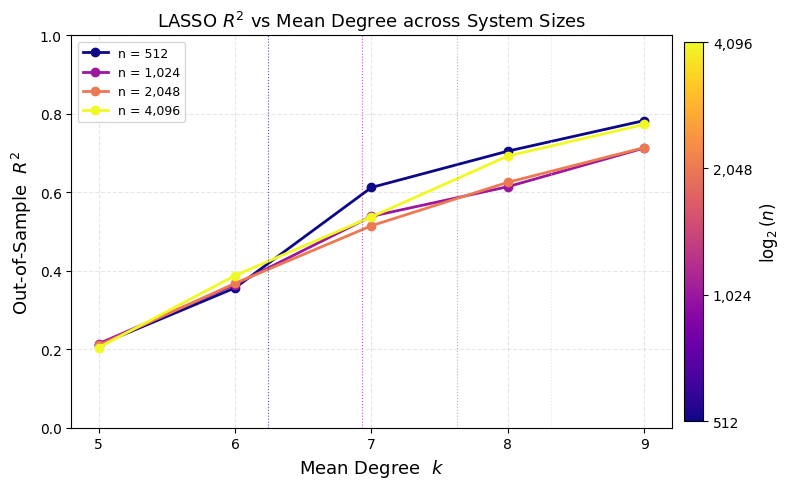

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------
# DATA OBTAINED FROM PREVIOUS CELLS
# ------------------------------------------------------
data = [
    (512,  5, 0.2108), (512,  6, 0.3565), (512,  7, 0.6125), (512,  8, 0.7051), (512,  9, 0.7830),
    (1024, 5, 0.2142), (1024, 6, 0.3649), (1024, 7, 0.5389), (1024, 8, 0.6144), (1024, 9, 0.7130),
    (2048, 5, 0.2101), (2048, 6, 0.3681), (2048, 7, 0.5149), (2048, 8, 0.6256), (2048, 9, 0.7141),
    (4096, 5, 0.2043), (4096, 6, 0.3880), (4096, 7, 0.5375), (4096, 8, 0.6927), (4096, 9, 0.7730),
]

n_values = sorted(set(d[0] for d in data))
k_values = sorted(set(d[1] for d in data))

# Organise into dict: r2[n][k] = r2
r2 = {n: {} for n in n_values}
for n, k, val in data:
    r2[n][k] = val

# ------------------------------------------------------
# PLOT
# ------------------------------------------------------
cmap = plt.cm.plasma
norm = plt.Normalize(vmin=np.log2(min(n_values)), vmax=np.log2(max(n_values)))

fig, ax = plt.subplots(figsize=(8, 5))

for n in n_values:
    ks   = sorted(r2[n].keys())
    vals = [r2[n][k] for k in ks]
    color = cmap(norm(np.log2(n)))
    ax.plot(ks, vals, marker='o', linewidth=2, markersize=6, color=color, label=f"n = {n:,}")

# Vertical lines at k = ln(n) for each n
for n in n_values:
    color = cmap(norm(np.log2(n)))
    ax.axvline(np.log(n), color=color, linewidth=0.8, linestyle=':', alpha=0.7)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label(r"$\log_2(n)$", fontsize=12)
cbar.set_ticks([np.log2(n) for n in n_values])
cbar.set_ticklabels([f"{n:,}" for n in n_values])

ax.set_xlabel("Mean Degree  $k$", fontsize=13)
ax.set_ylabel("Out-of-Sample  $R^2$", fontsize=13)
ax.set_title("LASSO $R^2$ vs Mean Degree across System Sizes", fontsize=13)
ax.set_xticks(k_values)
ax.set_ylim(0, 1)
ax.axhline(1.0, color='k', linewidth=0.8, linestyle='--', alpha=0.3)
ax.legend(fontsize=9)
ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig("r2_vs_k.png", dpi=150)
plt.show()